# Shampoo Sales

## Импортируем модули и определяем функции

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import pmdarima as pmd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


def get_plot(df, column):
    df[column].plot(figsize=(12, 10),
                    linewidth=5, fontsize=20)
    plt.xlabel('Month', fontsize=20)
    plt.ylabel('Sales per month',
               fontsize=20)
    plt.show()


def MAPE(true, pred):
    true, pred = np.array(true), np.array(pred)
    return np.mean(np.abs((true - pred) / true)) * 100

## Задание 1

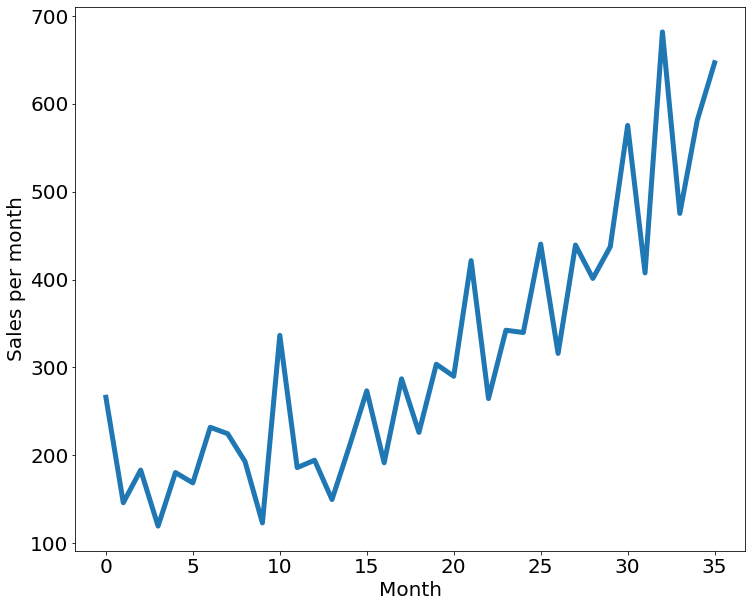

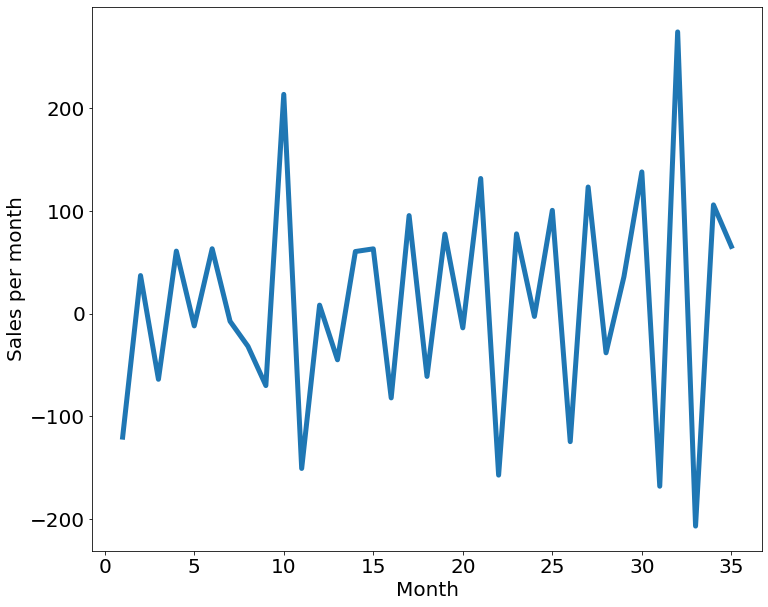

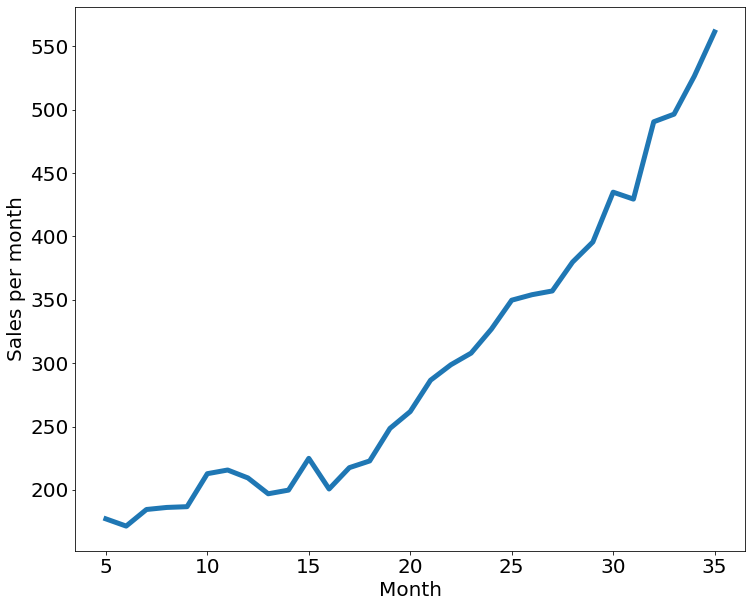

In [2]:
# читаем input-файл
df = pd.read_csv('Shift+Enter_Задания P&G_Data_Аnalyst_Shampoo.csv')
sales = df[['Sales']]

# строим график продаж
get_plot(df, 'Sales')

# add first-order difference & rolling average
df['sales_diff'] = df['Sales'].diff()
df['sales_ra'] = df['Sales'].rolling(6).mean()

# сplot first-order difference
get_plot(df, 'sales_diff')

# plot rolling average
get_plot(df, 'sales_ra')

Продажи имеют сильную волатильность от месяца к месяцу. Можно наблюдать пики в конце каждого года.

В целом, имеется восходящий тренд - за 3 года ежемесячные продажи возросли в 3 раза.

## Задание 2

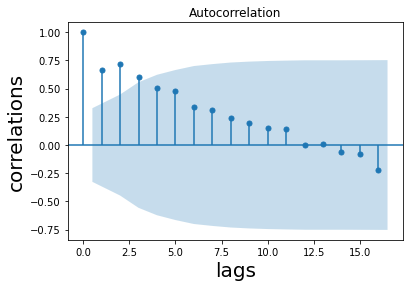

In [3]:
# the autocorrelation function
# lags on the horizontal and the correlations on vertical axis
plot_acf(sales)
plt.xlabel('lags', fontsize=20)
plt.ylabel('correlations',
           fontsize=20)
plt.show()

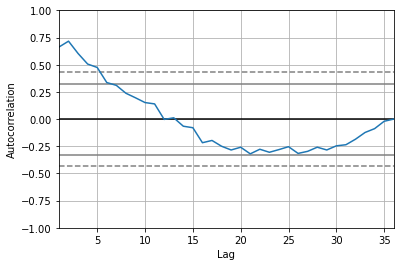

In [4]:
# the autocorrelation function
# lags on the horizontal and the correlations on vertical axis
# P&G-suggested Plot
pd.plotting.autocorrelation_plot(sales)
plt.show()

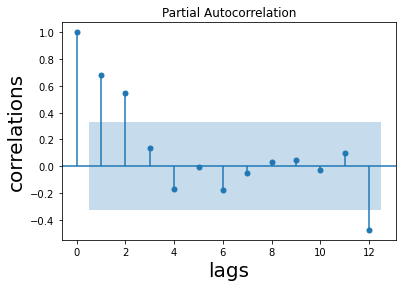

In [5]:
# the partial autocorrelation function
# lags on the horizontal and the correlations on vertical axis
plot_pacf(sales, lags=12)
plt.xlabel('lags', fontsize=20)
plt.ylabel('correlations',
           fontsize=20)
plt.show()

Положительная автокорреляция на лагах 1-12, на лагах 13 и далее - отрицательная.

Частичная автокорреляция отрицательна при лагах 4-7, 10 и 12. На лашах 1-3, 8-9 и 11 - положительная.

# Задание 3

In [6]:
# splitting dataset for train and test
y = df.Sales.values
train_set, test_set = train_test_split(y, test_size=0.40, random_state=42)

arima_model = pmd.auto_arima(train_set,
                             start_p=0, d=1, start_q=0,
                             test="adf", supress_warnings=True,
                             trace=True, random_state=42)

# Summary of the model
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=274.755, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=257.827, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=272.774, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=259.361, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=259.297, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=255.838, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=257.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=257.311, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.269 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -125.919
Date:                Sun, 01 Aug 2021   AIC                            255.838
Time:                        11:34:41   BIC                            257.829
Sample:                             0   HQIC                           256.227
                                 - 21                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7750      0.145     -5.333      0.000      -1.060      -0.490
sigma2      1.647e+04   8128.755      2.027      0.043     542.900    3.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.46   Prob(JB):                         0.39
Heteroskedasticity (H):               1.20   Skew:                             0.65
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# Predict the future values
predict_set = arima_model.predict(n_periods=len(test_set))

MAPE(test_set, predict_set)

54.87215949973297

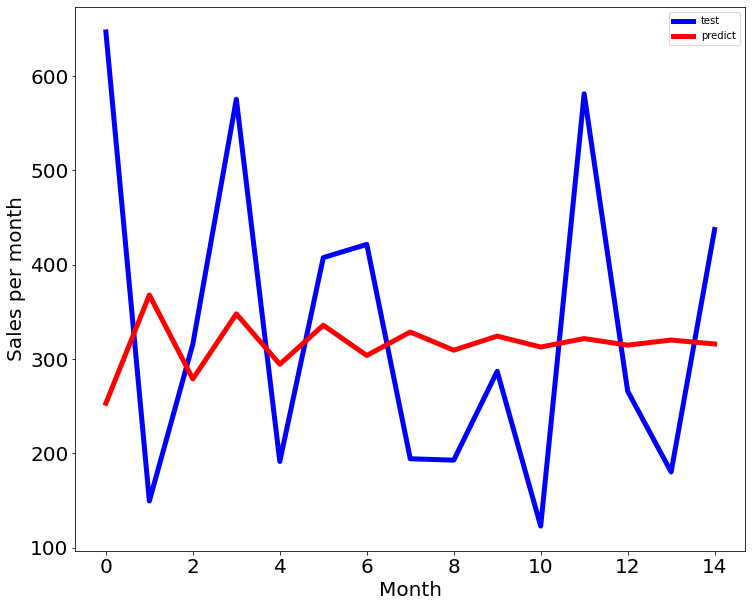

In [8]:
# plot test and predict data
df_compare = pd.DataFrame(
    list(zip(test_set, predict_set)), columns=['test', 'predict'])

df_compare.test.plot(figsize=(12, 10),
                     linewidth=5, fontsize=20, color='blue', label='test')
df_compare.predict.plot(figsize=(12, 10),
                        linewidth=5, fontsize=20, color='red', label='predict')
plt.xlabel('Month', fontsize=20)
plt.ylabel('Sales per month',
           fontsize=20)
plt.legend(loc='best')
plt.show()

# submit predtictions to a file
df_compare.to_csv('submission.csv')

In [9]:
# P&G-suggested ARIMA-model and plot

size = int(len(sales) * 0.65)
train_set, test_set = sales.values[0:size], sales.values[size:len(sales)]
history = [x for x in train_set]
predictions = list()

# walk-forward валидация
for t in range(len(test_set)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions.append(output[0])
    history.append(test_set[t])
    print('predicted=%f, expected=%f' % (output[0], test_set[t]))

predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220222, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415020, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231275, expected=475.300000
predicted=672.914944, expected=581.300000
predicted=531.541449, expected=646.900000


In [10]:
# оценка прогнозов
rmse = sqrt(mean_squared_error(test_set, predictions))
print('test RMSE: %.3f' % rmse)

test RMSE: 89.021


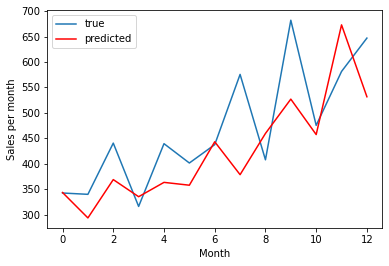

In [11]:
# строим график прогноз vs. актуальные значения
plt.plot(test_set, label='true')
plt.plot(predictions, color='red', label='predicted')
plt.xlabel('Month')
plt.ylabel('Sales per month')
plt.legend()
plt.show()